In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Dataset

In [2]:
from poc_data import PocDataset

poc_raw_dataset = PocDataset(num_cases=2**16)
data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=128)
batch, event, time_to_event, _latent_variable = next(iter(data_loader))

print(batch.shape)
print(event.shape)
print(time_to_event.shape)
print(_latent_variable.shape)

torch.Size([128, 30, 3])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


### Data Exploration

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.]])
tensor([[26.],
        [ 8.],
        [12.],
        [26.],
        [ 1.]])
tensor([[0.8963],
        [0.2468],
        [0.3954],
        [0.8874],
        [0.0063]])


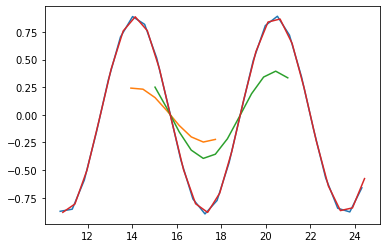

In [3]:
#Take a look at the longitudional data

plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

print(event[:5])
print(time_to_event[:5])
print(_latent_variable[:5])

# 2. Hyperparameters

# 3. Defining The Model

In [4]:
from dynamicDeepHit import sharedSubnetwork

model = sharedSubnetwork(num_covariates=3, hidden_states=32)

In [5]:
batch, event, time_to_event, _latent_variable = next(iter(data_loader))
y, gru_hidden = model(batch)

print(y.shape)
print(gru_hidden.shape)

torch.Size([128, 30, 3])
torch.Size([1, 128, 32])


# 4. Training the model

In [6]:

from torch.nn import MSELoss
from tqdm import trange

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

NUM_EPOCHS = 30
LEARNING_RATE = 0.001

writer = SummaryWriter()

# initialize model
model.to('cuda')
 
# intialize optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
 
# initialize loss
mse_loss = MSELoss()

# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for i, data in enumerate(data_loader):

    data = batch, _, _, _

    # bringing batches to GPU
    batch = batch.to('cuda')

    # zero parameter gradient
    optimizer.zero_grad()

    # forward, backward, optimize
    outputs, _ = model(batch)

    # Since we use multi-loss training we have a classification target at each time step,
    #   T different loss values for each entry in the batch
    #     btw: https://www.youtube.com/watch?v=7q7E91pHoW4 (crossloss)
    loss3 = mse_loss(outputs[:-1], batch.detach()[1:])

    epoch_loss += loss3

    loss3.backward()
    optimizer.step()
  
  writer.add_scalar('Loss/Train', epoch_loss.item(), epoch)
  print("av_epoch_train_loss=", epoch_loss.item()/len(data_loader))

  5%|▌         | 1/20 [00:02<00:52,  2.78s/it]

av_epoch_train_loss= 801.0703125


 10%|█         | 2/20 [00:05<00:51,  2.88s/it]

av_epoch_train_loss= 584.9972534179688


 15%|█▌        | 3/20 [00:08<00:48,  2.83s/it]

av_epoch_train_loss= 475.5477600097656


 20%|██        | 4/20 [00:11<00:45,  2.86s/it]

av_epoch_train_loss= 397.77130126953125


 25%|██▌       | 5/20 [00:14<00:42,  2.84s/it]

av_epoch_train_loss= 350.2627868652344


 30%|███       | 6/20 [00:16<00:38,  2.77s/it]

av_epoch_train_loss= 324.27203369140625


 35%|███▌      | 7/20 [00:19<00:36,  2.79s/it]

av_epoch_train_loss= 308.4941711425781


 40%|████      | 8/20 [00:22<00:33,  2.80s/it]

av_epoch_train_loss= 294.0893249511719


 45%|████▌     | 9/20 [00:25<00:31,  2.85s/it]

av_epoch_train_loss= 280.1318359375


 50%|█████     | 10/20 [00:28<00:27,  2.78s/it]

av_epoch_train_loss= 273.41632080078125


 55%|█████▌    | 11/20 [00:30<00:24,  2.75s/it]

av_epoch_train_loss= 303.93499755859375


 60%|██████    | 12/20 [00:33<00:21,  2.72s/it]

av_epoch_train_loss= 298.1588134765625


 65%|██████▌   | 13/20 [00:36<00:19,  2.80s/it]

av_epoch_train_loss= 282.6579895019531


 70%|███████   | 14/20 [00:39<00:16,  2.81s/it]

av_epoch_train_loss= 280.11834716796875


 75%|███████▌  | 15/20 [00:41<00:13,  2.76s/it]

av_epoch_train_loss= 258.768798828125


 80%|████████  | 16/20 [00:44<00:10,  2.75s/it]

av_epoch_train_loss= 241.7493896484375


 85%|████████▌ | 17/20 [00:47<00:08,  2.77s/it]

av_epoch_train_loss= 262.3984375


 90%|█████████ | 18/20 [00:50<00:05,  2.78s/it]

av_epoch_train_loss= 253.48843383789062


 95%|█████████▌| 19/20 [00:52<00:02,  2.69s/it]

av_epoch_train_loss= 244.0281982421875


100%|██████████| 20/20 [00:55<00:00,  2.76s/it]

av_epoch_train_loss= 256.6794738769531
